In [1]:
import os
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, AveragePooling2D, Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-11-12 18:53:17.280149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 18:53:17.280197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 18:53:17.280225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 18:53:17.286913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 18:53:17.987914: W tensorflow/compiler/

In [2]:
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(224,224))
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def deprocess(image):
    # perform the inverse of the pre processing step
    img = image
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [3]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(validation_split=0.15,
                                     preprocessing_function=preprocess_input)

In [4]:
# Using only 2 classes to train the cnn model. We will train a cnn model for binary classification of whether a 
# painting is made by Vincent Van Gogh or by Edgar Degas

train_data_dir = 'Artists/images/'

class_subset = ['class_0', 'class_1'] 

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 1343 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


In [5]:
# Define the CNN architecture

def create_model(input_shape, optimizer='adam'):
    input_layer = Input(shape=input_shape)  
    
    conv1 = Conv2D(32, (3,3), activation='relu', name='b1c1')(input_layer)
    conv2 = Conv2D(64, (2,3), activation='relu', name='b1c2')(conv1)
    pool1 = AveragePooling2D((2,2), strides=(2,2))(conv2)
#     drop1 = Dropout(0.25)(pool1)
    
    conv3 = Conv2D(64, (3,3), activation='relu', name='b2c1')(pool1)
    pool2 = AveragePooling2D((2,2), strides=(2,2))(conv3)
#     drop2 = Dropout(0.25)(pool2)
    
    conv4 = Conv2D(128, (3,3), activation='relu', name='b3c1')(pool2)
    pool3 = AveragePooling2D((2,2), strides=(2,2))(conv4)
#     drop3 = Dropout(0.25)(pool3)
    
    flatt = Flatten()(pool3)
    dens1 = Dense(512, activation='relu')(flatt)
#     drop4 = Dropout(0.5)(dens1)
    
    output_layer = Dense(1, activation='sigmoid')(dens1) 
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
# defining model parameters

input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 15

cnn_model = create_model(input_shape)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 b1c1 (Conv2D)               (None, 222, 222, 32)      896       
                                                                 
 b1c2 (Conv2D)               (None, 221, 220, 64)      12352     
                                                                 
 average_pooling2d (Average  (None, 110, 110, 64)      0         
 Pooling2D)                                                      
                                                                 
 b2c1 (Conv2D)               (None, 108, 108, 64)      36928     
                                                                 
 average_pooling2d_1 (Avera  (None, 54, 54, 64)        0         
 gePooling2D)                                                

In [7]:
# Can either train the model or load the already trained model
# The training accuracy of the model was around 99% and test accuracy was 80%

# cnn_history = cnn_model.fit(traingen,
#                             batch_size=BATCH_SIZE,
#                             epochs=n_epochs,
#                             validation_data=validgen,
#                             steps_per_epoch=n_steps,
#                             validation_steps=n_val_steps,
#                             verbose=1)
cnn_model = load_model('vvg_Edgar_cnn_50epoch')

In [8]:
# Content image is the image that is to be converted so that it looks like the style image.

content_path = 'Artists/images/content_images/swan.jpg'
style_path = 'Artists/images/class_0/Vincent_van_Gogh_368.jpg'

In [9]:
# the content model takes input image and gives output the feature map of the trained cnn model. To be exact
# it returns the output of the 3rd block 1st Conv2D layer.

content_layer = 'b3c1'
content_model = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(content_layer).output
)
content_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 b1c1 (Conv2D)               (None, 222, 222, 32)      896       
                                                                 
 b1c2 (Conv2D)               (None, 220, 220, 64)      18496     
                                                                 
 average_pooling2d_15 (Aver  (None, 110, 110, 64)      0         
 agePooling2D)                                                   
                                                                 
 b2c1 (Conv2D)               (None, 108, 108, 64)      36928     
                                                                 
 average_pooling2d_16 (Aver  (None, 54, 54, 64)        0         
 agePooling2D)                                             

In [10]:
# Similiar to content_models but for style we are considering multiple feature maps to output so the style_models has
# multiple models.

style_layers = ['b1c1','b1c2','b2c1']
style_models = [Model(inputs=cnn_model.input, 
                      outputs=cnn_model.get_layer(layer).output) for layer in style_layers]

# Intermediate Layers for style and content

As we see above the intermediate layers of cnn model is used for feature extraction of the style and content images, because at a higher level when we train a cnn model for classification, it tries to understand the image by doing the convolution operations, that is trying to find some patterns or correlations in the data. 

In [11]:
# The content loss is defined as the squared difference of the feature map extraction from cnn model
# of generated and content image

def content_loss(content, generated, content_model):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

In [39]:
# Gram matrix is a matrix that is used to quantify style. It is calculated by taking the outer product of the feature
# vector with itself at each location and averaging that outer product over all locations.

def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# style loss is calculated by the squared difference of gram matrix of the feature maps of the trained cnn
def style_loss(style, generated, style_models):
    loss = 0
    weight_of_layer = 1. / len(style_models)
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_loss = tf.reduce_mean(tf.square(GS - GG))
        loss += current_loss * weight_of_layer

    return loss

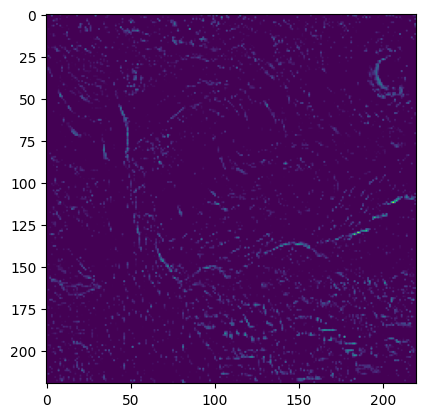

In [40]:
# Trying to visualize the feature maps of the cnn model

content = load_and_process_image(content_path)
style = load_and_process_image(style_path)

style_outputs = [model(style) for model in style_models]
ith_style_layer = 1      # there are three style layers so 0, 1 or 2
jth_feature_map = 15
plt.imshow(style_outputs[ith_style_layer][0][:,:,jth_feature_map])

In [42]:
# training function that does gradient descent with adam optimizer (l-bfgs gives better performance)

def training(content_path, style_path, content_model, style_models, iterations=100, content_weight=1e-2, style_weight=1000):
    # load content and style images from their respective path
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
    generated_images = []
    content_losses = []
    style_losses = []
    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_loss = 1e12
    best_image = None
    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss_content = content_loss(content, generated, content_model)
            loss_style = style_loss(style, generated, style_models)
            loss_total = content_weight * loss_content + style_weight * loss_style

        grads = tape.gradient(loss_total, generated)
        opt.apply_gradients([(grads, generated)])

        if loss_total < best_loss:
            best_loss = loss_total
            best_image = generated.numpy()

        print("Iteration :{}, Loss :{:e}".format(i, loss_total))
        generated_images.append(generated.numpy())
        content_losses.append(loss_content)
        style_losses.append(loss_style)

    return best_image, content_losses, style_losses

In [15]:
final_img, c_loss, s_loss = training(content_path, style_path, content_model, style_models)

Iteration :0, Loss :9.120901e+05
Iteration :1, Loss :5.425565e+05
Iteration :2, Loss :4.139657e+05
Iteration :3, Loss :3.488001e+05
Iteration :4, Loss :2.483161e+05
Iteration :5, Loss :1.775063e+05
Iteration :6, Loss :1.506475e+05
Iteration :7, Loss :1.422846e+05
Iteration :8, Loss :1.353761e+05
Iteration :9, Loss :1.293986e+05
Iteration :10, Loss :1.267540e+05
Iteration :11, Loss :1.235054e+05
Iteration :12, Loss :1.143218e+05
Iteration :13, Loss :9.991670e+04
Iteration :14, Loss :8.433616e+04
Iteration :15, Loss :6.951774e+04
Iteration :16, Loss :5.520099e+04
Iteration :17, Loss :4.180361e+04
Iteration :18, Loss :3.155458e+04
Iteration :19, Loss :2.704361e+04
Iteration :20, Loss :2.857933e+04
Iteration :21, Loss :3.279100e+04
Iteration :22, Loss :3.485699e+04
Iteration :23, Loss :3.267646e+04
Iteration :24, Loss :2.769085e+04
Iteration :25, Loss :2.225305e+04
Iteration :26, Loss :1.759368e+04
Iteration :27, Loss :1.399087e+04
Iteration :28, Loss :1.175691e+04
Iteration :29, Loss :1.1

In [16]:
con = deprocess(content[0])
sty = deprocess(style[0])
fin = deprocess(final_img[0])

Text(0.5, 1.0, 'Style')

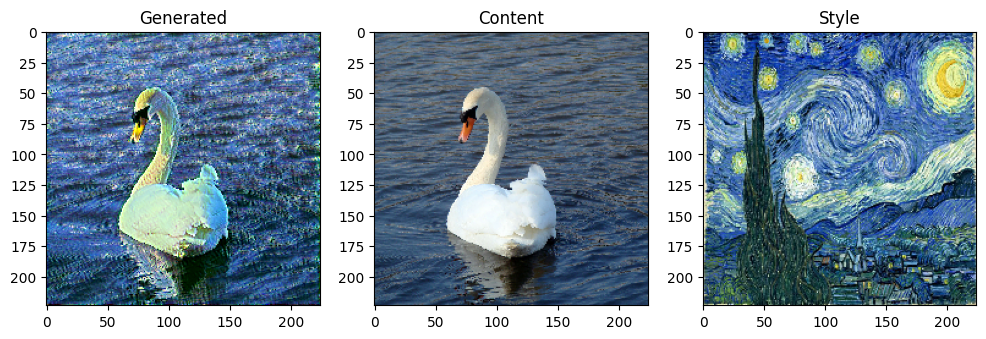

In [17]:
plt.figure(figsize=(12,36))
plt.subplot(1,3,1)
plt.imshow(fin)
plt.title("Generated")
plt.subplot(1,3,2)
plt.imshow(con)
plt.title("Content")
plt.subplot(1,3,3)
plt.imshow(sty)
plt.title("Style")

In [18]:
# Now we will try training on vgg19

from tensorflow.keras.applications.vgg19 import VGG19

In [19]:
vgg_model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
vgg_model.trainable = False
# Print details of different layers

vgg_content_layer = 'block5_conv2'
vgg_content_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer(vgg_content_layer).output)

vgg_style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
vgg_style_models = [Model(inputs=vgg_model.input,
                      outputs=vgg_model.get_layer(layer).output) for layer in vgg_style_layers]

In [20]:
vgg_final_image, vgg_c_loss, vgg_s_loss = training(content_path, style_path, vgg_content_model, vgg_style_models, iterations=50,
                                content_weight=10, style_weight=1000)

Iteration :0, Loss :6.325744e+11
Iteration :1, Loss :3.394867e+11
Iteration :2, Loss :1.981112e+11
Iteration :3, Loss :1.662284e+11
Iteration :4, Loss :1.088370e+11
Iteration :5, Loss :7.224659e+10
Iteration :6, Loss :6.346114e+10
Iteration :7, Loss :6.134572e+10
Iteration :8, Loss :5.577982e+10
Iteration :9, Loss :4.865597e+10
Iteration :10, Loss :4.236559e+10
Iteration :11, Loss :3.617474e+10
Iteration :12, Loss :3.045006e+10
Iteration :13, Loss :2.676618e+10
Iteration :14, Loss :2.476538e+10
Iteration :15, Loss :2.280426e+10
Iteration :16, Loss :2.051596e+10
Iteration :17, Loss :1.868508e+10
Iteration :18, Loss :1.756755e+10
Iteration :19, Loss :1.642989e+10
Iteration :20, Loss :1.499783e+10
Iteration :21, Loss :1.387466e+10
Iteration :22, Loss :1.323911e+10
Iteration :23, Loss :1.258541e+10
Iteration :24, Loss :1.167226e+10
Iteration :25, Loss :1.080923e+10
Iteration :26, Loss :1.018168e+10
Iteration :27, Loss :9.618844e+09
Iteration :28, Loss :9.053292e+09
Iteration :29, Loss :8.6

Text(0.5, 1.0, 'Style')

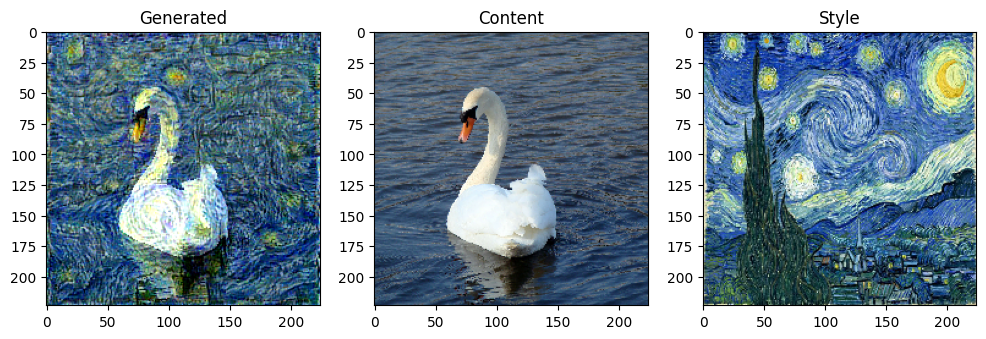

In [21]:
vgg_fin = deprocess(vgg_final_image[0])

plt.figure(figsize=(12,36))
plt.subplot(1,3,1)
plt.imshow(vgg_fin)
plt.title("Generated")
plt.subplot(1,3,2)
plt.imshow(con)
plt.title("Content")
plt.subplot(1,3,3)
plt.imshow(sty)
plt.title("Style")

In [23]:
# To evaluate the model based on style we can calculate the squared difference between the gram matrix of the 
# generated image and the original style imag which I will call the style difference

style_image_gram = gram_matrix(style[0])
cnn_model_gen_gram = gram_matrix(final_img[0])
vgg_model_gen_gram = gram_matrix(vgg_final_image[0])

Text(0.5, 0, 'iterations')

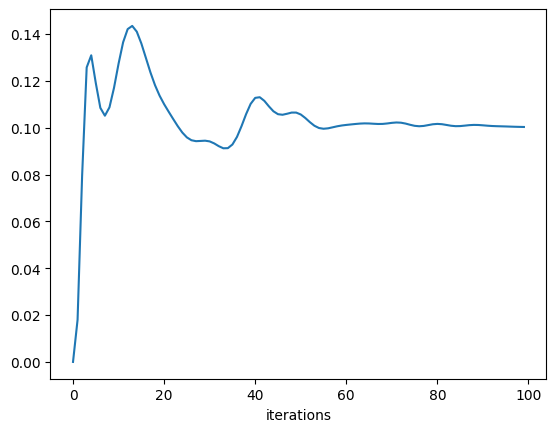

In [34]:
# plot of content loss of my custom cnn model with iterations
plt.plot(c_loss)
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

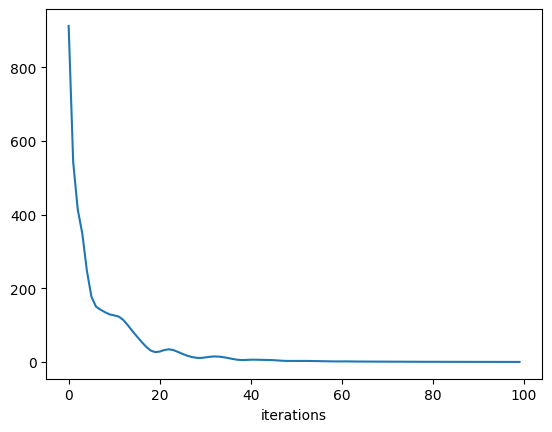

In [35]:
# plot of style loss of my custom cnn model with iterations
plt.plot(s_loss)
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

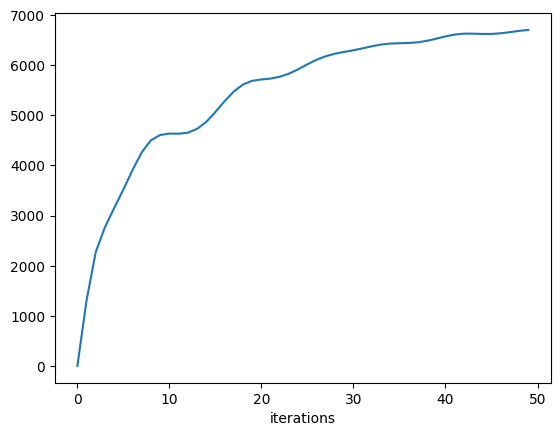

In [36]:
# plot of content loss for vgg19 model with iterations
plt.plot(vgg_c_loss)
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

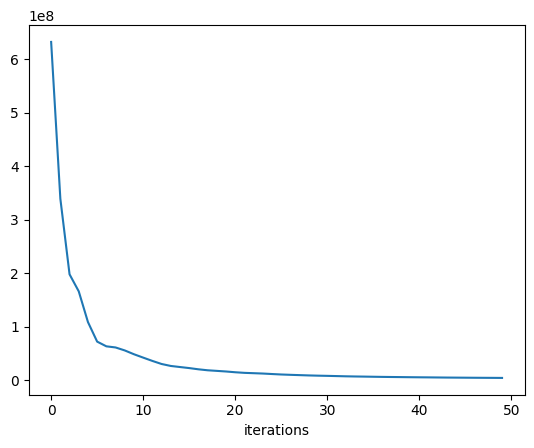

In [37]:
# plot of style loss for vgg19 model with iterations
plt.plot(vgg_s_loss)
plt.xlabel("iterations")

# Conclusion

We see that the image stylized by the vgg model has a better visual appeal than the custom cnn model trained by me

To make the model better we can try to retrain the vgg19 or vgg16 model on large art datasets like wikiart so that 
we get better artist style representation in the generated image.

Another way to make this faster is to use l-bfgs optimzer instead of adam optimizer, even though it is more computationally expensive, it is significantly faster.